In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

log_file = '../../submissions/round2/trader_jm_xf_make_round2_final.log'
timestamp_pattern = r"\"timestamp\": \d+"
observation_pattern = r'\[\d+.?\d,\d+.?\d+,\d+?.\d+,\d+.?\d,-\d+.?\d+,\d+.?\d+,\d+.?\d+]'
observation = pd.DataFrame(columns=['timestamp', 'ASK', 'BID', 'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY'])

with open(log_file, 'r') as f:
    lines = f.readlines()
    
    sandbox_start = 1
    sandbox_end = 2
    while not lines[sandbox_end] == '\n':
        if lines[sandbox_end].startswith('{'):
            sandbox_start = sandbox_end
            while not lines[sandbox_end].startswith('}'):
                sandbox_end += 1
            entry = ''.join(lines[sandbox_start:sandbox_end+1])
            time = re.findall(timestamp_pattern, entry)
            text = re.findall(observation_pattern, entry)
            if len(time) == 1 and len(text) == 1:
                time = int(time[0].split(' ')[1])
                text = text[0][1:-1].split(',')
                observation.loc[len(observation)] = [time] + [float(x) for x in text]
        sandbox_end += 1
    
    activity_start = 1
    while not lines[activity_start].startswith('Activities log:'):
        activity_start += 1
    activity_start += 1
    activity_end = activity_start + 1
    while lines[activity_end] != '\n':
        activity_end += 1

    trade_start = activity_end + 1
    while not lines[trade_start].startswith('Trade History:'):
        trade_start += 1
    trade_start += 1
    trade_end = len(lines)

    trade_history = ''.join(lines[trade_start:trade_end])

activity_log = pd.read_csv(log_file, skiprows=activity_start, nrows=activity_end-activity_start-1, sep=';')
trade_history = pd.read_json(trade_history)
market_trades = trade_history[(trade_history.buyer == '') & (trade_history.seller == '')]
own_trades = trade_history[(trade_history.buyer == 'SUBMISSION') | (trade_history.seller == 'SUBMISSION')]

trade_ORCHIDS = own_trades[own_trades['symbol'] == 'ORCHIDS'].set_index('timestamp')
activity_ORCHIDS = activity_log[activity_log['product'] == 'ORCHIDS'].set_index('timestamp')
observation['ORCHIDS'] = (observation['ASK'] + observation['BID'])/2
observation.to_csv('log/observation_from_round2_result.csv', index=False)

C:\Users\hnxxz\AppData\Local\Temp\ipykernel_8772\4136628934.py:47: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


In [12]:
observation = pd.read_csv('log/observation_from_round2_result.csv')
observation = observation.set_index('timestamp').reindex(activity_ORCHIDS.index)
observation

,ASK,BID,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,ORCHIDS
timestamp,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,1054.0,1055.5,1.0,8.0,-2.0,1100.8351,75.024070,1054.75
200,1054.0,1055.5,1.0,8.0,-2.0,1101.6697,75.048004,1054.75
300,1054.5,1056.0,1.0,8.0,-2.0,1102.5039,75.071810,1055.25
400,1055.5,1057.0,1.0,8.0,-2.0,1103.3376,75.095474,1056.25
...,...,...,...,...,...,...,...,...
999500,1051.0,1053.0,0.8,8.0,-4.0,2597.2483,69.917725,1052.00
999600,1050.5,1051.5,0.8,8.0,-4.0,2597.7950,69.934050,1051.00
999700,1051.0,1052.5,0.8,8.0,-4.0,2598.3435,69.950450,1051.75


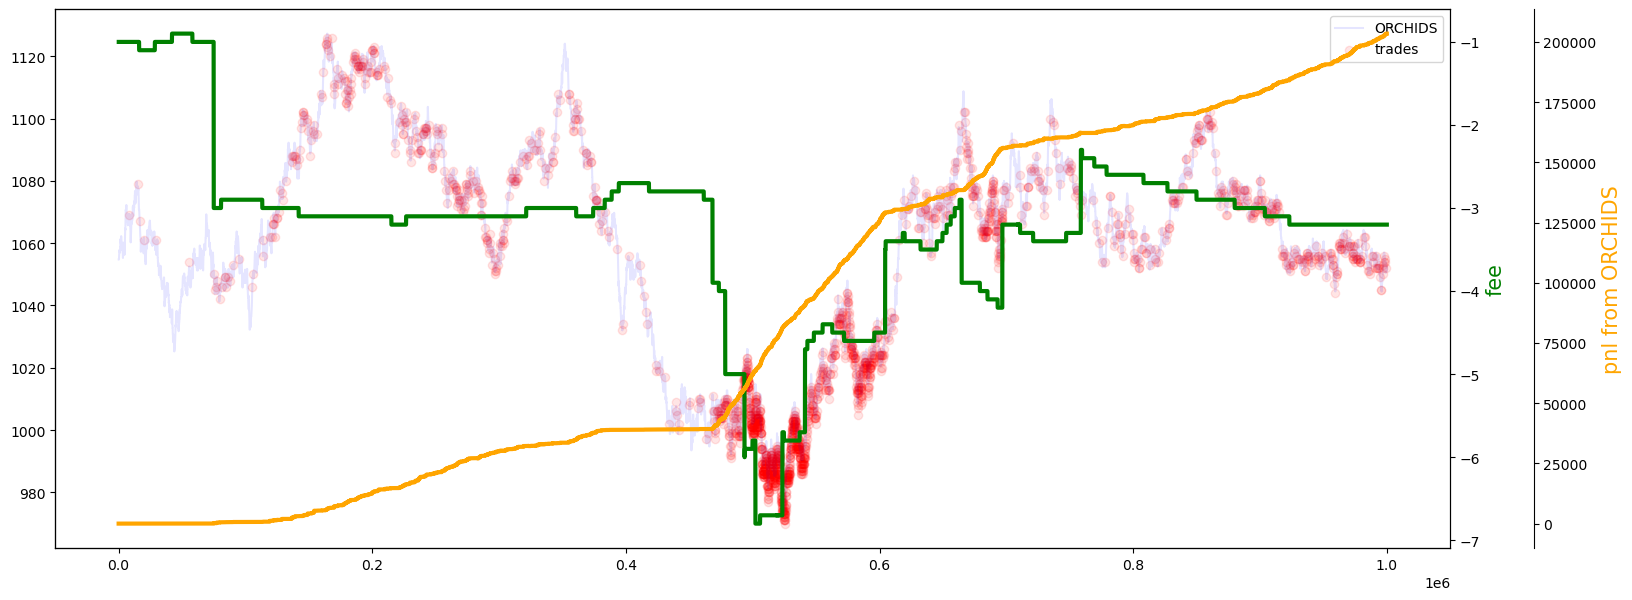

In [16]:
fee = observation['TRANSPORT_FEES'] + observation['IMPORT_TARIFF']
pnl = activity_ORCHIDS['profit_and_loss']
price = observation['ORCHIDS']

fig, ax = plt.subplots(figsize=(18, 7))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))
assert isinstance(ax, plt.Axes)
assert isinstance(ax2, plt.Axes)
assert isinstance(ax3, plt.Axes)

ax.plot(price , label='ORCHIDS', color='blue', alpha=0.1)
ax.scatter(trade_ORCHIDS.index, trade_ORCHIDS['price'], label='trades', color='red', alpha=0.1)
ax.legend()
ax2.plot(fee, label='fee', color='green', linewidth=3)
ax2.set_ylabel('fee', fontsize=15, color='green')
ax3.plot(pnl, label='pnl', color='orange', linewidth=3)
ax3.set_ylabel('pnl from ORCHIDS', fontsize=15, color='orange')
plt.show()

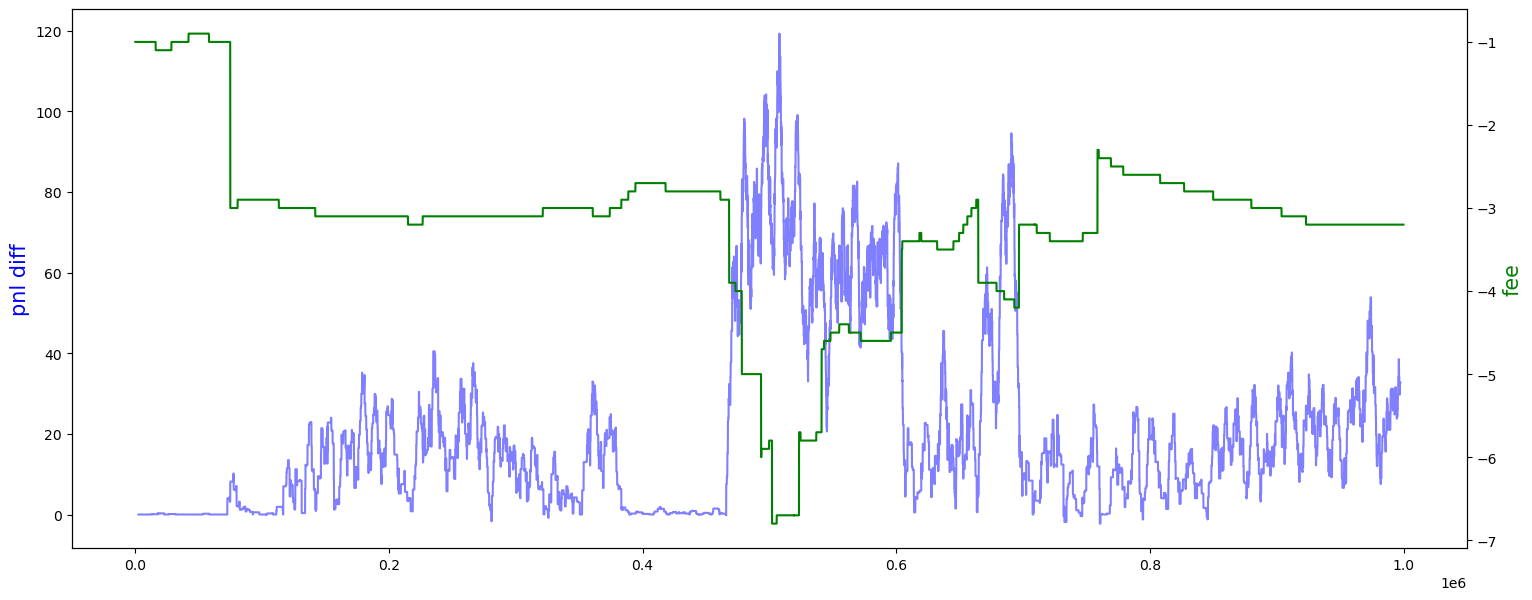

In [17]:
pnl_diff = pnl.diff().rolling(50, center=True).mean()

fig, ax = plt.subplots(figsize=(18, 7))
ax2 = ax.twinx()
assert isinstance(ax, plt.Axes)
assert isinstance(ax2, plt.Axes)

ax.plot(pnl_diff, label='pnl diff', color='blue', alpha=0.5)
ax.set_ylabel('pnl diff', fontsize=15, color='blue')
ax2.plot(fee, label='fee', color='green')
ax2.set_ylabel('fee', fontsize=15, color='green')
plt.show()

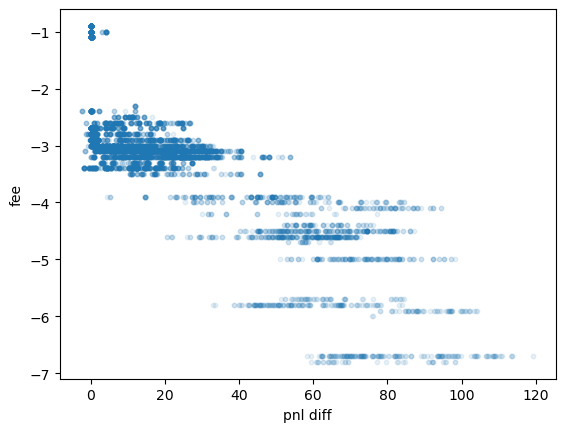

In [20]:
plt.scatter(pnl_diff, fee, s=10, alpha=0.1)
plt.xlabel('pnl diff')
plt.ylabel('fee')
plt.show()

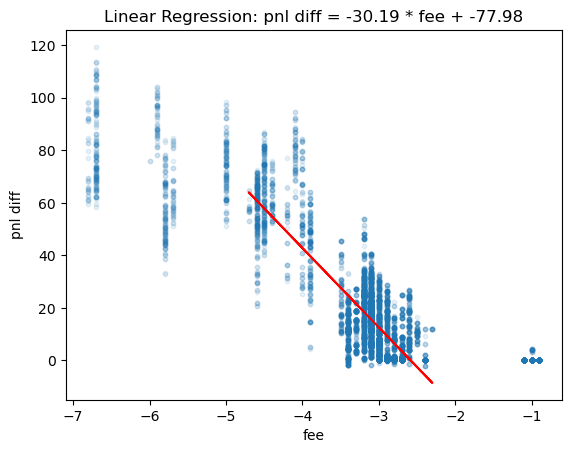

In [47]:
mask = (fee < -2) & (fee > -5)

pnl_diff_truc = pnl_diff[mask].dropna()
fee_truc = fee[mask].dropna()
common_index = pnl_diff_truc.index.intersection(fee_truc.index)
pnl_diff_truc = pnl_diff_truc.loc[common_index].values.reshape(-1, 1)
fee_truc = fee_truc.loc[common_index].values.reshape(-1, 1)

# do a linear regression
reg = LinearRegression().fit(fee_truc, pnl_diff_truc)

plt.scatter(fee, pnl_diff, s=10, alpha=0.1)
plt.plot(fee_truc, reg.predict(fee_truc), color='red')
plt.title('Linear Regression: pnl diff = %.2f * fee + %.2f' % (reg.coef_[0][0], reg.intercept_[0]))
plt.xlabel('fee')
plt.ylabel('pnl diff')
plt.show()

In [48]:
# r square
r2_score(pnl_diff_truc, reg.predict(fee_truc))

0.6510919275227008